Welcome!

So glad you made it and thanks for checking out HyenaDNA! We're \**very*\* excited to get this in the hands of researchers.

Let's walk through how to setup a simple HyenaDNA model to:

*    Train on the GenomicBenchmarks dataset from scratch or fine-tune (sequence level classification tasks)
*    Load from HuggingFace :)
*    Do inference on up to 1M tokens!

--

After this tutorial, you can check out more advanced training (more configurable and optimized for speed) through the HyenaDNA repo, which uses Pytorch Lightning and Hydra for managing all the experimental configs and settings.

Luckily, the code for classification here is 95% the same as the pretraining code!

- [arxiv](https://arxiv.org/abs/2306.15794)  
- [blog](https://hazyresearch.stanford.edu/blog/2023-06-29-hyena-dna)
- [github](https://github.com/HazyResearch/hyena-dna)  
- [huggingface](https://huggingface.co/LongSafari) (pretrained weights)  

Good luck and enjoy!!!

\\
Credit: much of the code is forked and extended from [S4](https://github.com/HazyResearch/state-spaces) and [Safari](https://github.com/HazyResearch/safari).

In [1]:
#@title Installs
# !pip install einops
# !pip install torchvision
# !pip install transformers==4.26.1
# !pip install genomic-benchmarks
# !pip install OmegaConf


In [2]:
#@title Imports
# for HyenaDNA specifically
import torch
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from functools import partial
from einops import rearrange
from typing import Optional
from functools import partial
from torch import Tensor
from torchvision.ops import StochasticDepth
from collections import namedtuple
print(torch.version.cuda)
import sys
sys.executable.split('/')[-3]
!nvidia-smi
torch.cuda.device_count()

11.7
Fri Aug 30 12:56:00 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  On   | 00000000:CA:00.0 Off |                    0 |
| N/A   35C    P0    56W / 300W |    121MiB / 81920MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+--

1

In [3]:
#my imports
import ftplib
import os
import pandas as pd
import youtokentome as yttm
from functools import partial
import gzip
from BCBio import GFF 
import numpy as np
import smart_open 
import gensim 
from sklearn.model_selection import train_test_split 
import matplotlib.pyplot as plt 
import sqlite3
# import sqlalchemy 
from matplotlib import cm
from tables import * 
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = ""
os.environ['CUDA_LAUNCH_BLOCKING']='1'
import datetime
import jupyter_beeper
beep = jupyter_beeper.Beeper()


In [4]:
str(datetime.date.today())

'2024-08-30'

# HyenaDNA



In [5]:
#@title Hyena layer


def fftconv(u, k, D):
    """
    We apply a convolution through the fourier domain (from the Convolution Theorem)

    """
    seqlen = u.shape[-1]
    fft_size = 2 * seqlen

    k_f = torch.fft.rfft(k, n=fft_size) / fft_size
    u_f = torch.fft.rfft(u.to(dtype=k.dtype), n=fft_size)

    if len(u.shape) > 3: k_f = k_f.unsqueeze(1)
    y = torch.fft.irfft(u_f * k_f, n=fft_size, norm='forward')[..., :seqlen]

    out = y + u * D.unsqueeze(-1)
    return out.to(dtype=u.dtype)


@torch.jit.script
def mul_sum(q, y):
    return (q * y).sum(dim=1)

class OptimModule(nn.Module):
    """ Interface for Module that allows registering buffers/parameters with configurable optimizer hyperparameters """

    def register(self, name, tensor, lr=None, wd=0.0):
        """Register a tensor with a configurable learning rate and 0 weight decay"""

        if lr == 0.0:
            self.register_buffer(name, tensor)
        else:
            self.register_parameter(name, nn.Parameter(tensor))

            optim = {}
            if lr is not None: optim["lr"] = lr
            if wd is not None: optim["weight_decay"] = wd
            setattr(getattr(self, name), "_optim", optim)


class Sin(nn.Module):
    """The Sin activation function for the Hyena Filter function."""
    def __init__(self, dim, w=10, train_freq=True):
        super().__init__()
        self.freq = nn.Parameter(w * torch.ones(1, dim)) if train_freq else w * torch.ones(1, dim)

    def forward(self, x):
        return torch.sin(self.freq * x)


class PositionalEmbedding(OptimModule):
    def __init__(self, emb_dim: int, seq_len: int, lr_pos_emb: float=1e-5, **kwargs):
        """Complex exponential positional embeddings for Hyena filters."""
        super().__init__()

        self.seq_len = seq_len
        # The time embedding fed to the filteres is normalized so that t_f = 1
        t = torch.linspace(0, 1, self.seq_len)[None, :, None] # 1, L, 1

        if emb_dim > 1:
            bands = (emb_dim - 1) // 2
        # To compute the right embeddings we use the "proper" linspace
        t_rescaled = torch.linspace(0, seq_len - 1, seq_len)[None, :, None]
        w = 2 * math.pi * t_rescaled / seq_len # 1, L, 1

        f = torch.linspace(1e-4, bands - 1, bands)[None, None]
        z = torch.exp(-1j * f * w)
        z = torch.cat([t, z.real, z.imag], dim=-1)
        self.register("z", z, lr=lr_pos_emb)
        self.register("t", t, lr=0.0)

    def forward(self, L):
        return self.z[:, :L], self.t[:, :L]


class ExponentialModulation(OptimModule):
    """The window function applied to the output of the (MLP) filter function."""
    def __init__(
        self,
        d_model,
        fast_decay_pct=0.3,
        slow_decay_pct=1.5,
        target=1e-2,
        modulation_lr=0.0,
        modulate: bool=True,
        shift: float = 0.05,
        **kwargs
    ):
        super().__init__()
        self.modulate = modulate
        self.shift = shift
        max_decay = math.log(target) / fast_decay_pct
        min_decay = math.log(target) / slow_decay_pct
        deltas = torch.linspace(min_decay, max_decay, d_model)[None, None]
        self.register("deltas", deltas, lr=modulation_lr)

    def forward(self, t, x):
        if self.modulate:
            decay = torch.exp(-t * self.deltas.abs())
            x = x * (decay + self.shift)
        return x


class HyenaFilter(OptimModule):
    def __init__(
            self,
            d_model,
            emb_dim=3, # dim of input to MLP, augments with positional encoding
            order=16, # width of the implicit MLP
            fused_fft_conv=False,
            seq_len=1024,
            lr=1e-3,
            lr_pos_emb=1e-5,
            dropout=0.0,
            w=1, # frequency of periodic activations
            wd=0, # weight decay of kernel parameters
            bias=True,
            num_inner_mlps=2,
            normalized=False,
            **kwargs
        ):
        """
        Implicit long filter with modulation.

        Args:
            d_model: number of channels in the input
            emb_dim: dimension of the positional encoding (`emb_dim` - 1) // 2 is the number of bands
            order: width of the FFN
            num_inner_mlps: number of inner linear layers inside filter MLP

        Note:
            filter_dropout is not implemented
        """
        super().__init__()

        self.d_model = d_model
        self.use_bias = bias
        self.fused_fft_conv = fused_fft_conv
        self.bias = nn.Parameter(torch.randn(self.d_model))
        self.dropout = nn.Dropout(dropout)

        act = Sin(dim=order, w=w)
        self.emb_dim = emb_dim
        assert emb_dim % 2 != 0 and emb_dim >= 3, "emb_dim must be odd and greater or equal to 3 (time, sine and cosine)"
        self.seq_len = seq_len

        self.pos_emb = PositionalEmbedding(emb_dim, seq_len, lr_pos_emb)

        self.implicit_filter = nn.Sequential(
            nn.Linear(emb_dim, order),
            act,
        )
        for i in range(num_inner_mlps):
            self.implicit_filter.append(nn.Linear(order, order))
            self.implicit_filter.append(act)

        self.implicit_filter.append(nn.Linear(order, d_model, bias=False))

        self.modulation = ExponentialModulation(d_model, **kwargs)

        self.normalized = normalized
        for c in self.implicit_filter.children():
            for name, v in c.state_dict().items():
                optim = {"weight_decay": wd, "lr": lr}
                setattr(getattr(c, name), "_optim", optim)

    def filter(self, L, *args, **kwargs):
        z, t = self.pos_emb(L)
        h = self.implicit_filter(z)
        h = self.modulation(t, h)
        return h

    def forward(self, x, L, k=None, bias=None, *args, **kwargs):
        if k is None: k = self.filter(L)

        # Ensure compatibility with filters that return a tuple
        k = k[0] if type(k) is tuple else k
        # print("shape of x and k:", x.shape, k.shape)
        y = fftconv(x, k, bias)
        # print("shape of y:", y.shape)
        return y


class HyenaOperator(nn.Module):
    def __init__(
            self,
            d_model,
            l_max,
            order=2,
            filter_order=64,
            dropout=0.0,
            filter_dropout=0.0,
            **filter_args,
        ):
        r"""
        Hyena operator described in the paper https://arxiv.org/pdf/2302.10866.pdf

        Args:
            d_model (int): Dimension of the input and output embeddings (width of the layer)
            l_max: (int): Maximum input sequence length. Defaults to None
            order: (int): Depth of the Hyena recurrence. Defaults to 2
            dropout: (float): Dropout probability. Defaults to 0.0
            filter_dropout: (float): Dropout probability for the filter. Defaults to 0.0
        """
        super().__init__()

        self.d_model = d_model
        self.l_max = l_max
        self.order = order
        inner_width = d_model * (order + 1)
        self.dropout = nn.Dropout(dropout)
        self.in_proj = nn.Linear(d_model, inner_width)
        self.out_proj = nn.Linear(d_model, d_model)

        self.short_filter = nn.Conv1d(
            inner_width,
            inner_width,
            3,
            padding=2,
            groups=inner_width
        )
        self.filter_fn = HyenaFilter(
            d_model * (order - 1),
            order=filter_order,
            seq_len=l_max,
            channels=1,
            dropout=filter_dropout,
            **filter_args
        )

    def forward(self, u, *args, **kwargs):
        l = u.size(-2)
        l_filter = min(l, self.l_max)
        # print("shape of u:",u.shape)
        u = self.in_proj(u)
        u = rearrange(u, 'b l d -> b d l')

        uc = self.short_filter(u)[...,:l_filter]
        *x, v = uc.split(self.d_model, dim=1)

        k = self.filter_fn.filter(l_filter)[0]
        k = rearrange(k, 'l (o d) -> o d l', o=self.order - 1)
        bias = rearrange(self.filter_fn.bias, '(o d) -> o d', o=self.order - 1)

        for o, x_i in enumerate(reversed(x[1:])):
            v = self.dropout(v * x_i)
            v = self.filter_fn(v, l_filter, k=k[o], bias=bias[o])

        y = rearrange(v * x[0], 'b d l -> b l d')

        y = self.out_proj(y)
        # print("y shape (operator):", y.shape)
        return y


In [6]:
#@title Self-Attention (alternative)

"""
If you'd like to try the HyenaDNA model using attention instead, you can. ie,
use a regular decoder only Transformer.

Borrowed from the FlashAttention library by Tri Dao.
"""

class SelfAttention(nn.Module):
    """Implement the scaled dot product attention with softmax.
    Arguments
    ---------
        softmax_scale: The temperature to use for the softmax attention.
                      (default: 1/sqrt(d_keys) where d_keys is computed at
                      runtime)
        attention_dropout: The dropout rate to apply to the attention
                           (default: 0.0)
    """
    def __init__(self, causal=False, softmax_scale=None, attention_dropout=0.0):
        super().__init__()
        self.causal = causal
        self.softmax_scale = softmax_scale
        self.dropout_p = attention_dropout

    def forward(self, qkv, causal=None, key_padding_mask=None):
        """Implements the multihead softmax attention.
        Arguments
        ---------
            qkv: The tensor containing the query, key, and value. (B, S, 3, H, D)
            causal: if passed, will override self.causal
            key_padding_mask: boolean mask to apply to the attention weights. True means to keep,
                False means to mask out. (B, S)
        """
        batch_size, seqlen = qkv.shape[0], qkv.shape[1]
        causal = self.causal if causal is None else causal
        q, k, v = qkv.unbind(dim=2)
        softmax_scale = self.softmax_scale or 1.0 / math.sqrt(q.shape[-1])
        scores = torch.einsum('bthd,bshd->bhts', q, k * softmax_scale)
        if key_padding_mask is not None:
            padding_mask = torch.full((batch_size, seqlen), -10000.0, dtype=scores.dtype,
                                      device=scores.device)
            padding_mask.masked_fill_(key_padding_mask, 0.0)
            scores = scores + rearrange(padding_mask, 'b s -> b 1 1 s')
        if causal:
            # "triu_tril_cuda_template" not implemented for 'BFloat16'
            # So we have to construct the mask in float
            causal_mask = torch.triu(torch.full((seqlen, seqlen), -10000.0, device=scores.device), 1)
            scores = scores + causal_mask.to(dtype=scores.dtype)
        attention = torch.softmax(scores, dim=-1, dtype=v.dtype)
        attention_drop = F.dropout(attention, self.dropout_p if self.training else 0.0)
        output = torch.einsum('bhts,bshd->bthd', attention_drop, v)
        return output

class MHA(nn.Module):
    """Multi-head self-attention and cross-attention
    """

    def __init__(self, embed_dim, num_heads, bias=True, dropout=0.0,
                 softmax_scale=None, causal=False, layer_idx=None, dwconv=False,return_residual=False,device=None, dtype=None) -> None:
        """
            return_residual: whether to return the input x along with the output. This is for
                performance reason: for post-norm architecture, returning the input allows us
                to fuse the backward of nn.Linear with the residual connection.
        """
        factory_kwargs = {'device': device, 'dtype': dtype}
        super().__init__()
        self.embed_dim = embed_dim
        self.causal = causal
        self.layer_idx = layer_idx
        self.dwconv = dwconv
        self.return_residual = return_residual

        self.num_heads = num_heads
        assert self.embed_dim % num_heads == 0, "self.kdim must be divisible by num_heads"
        self.head_dim = self.embed_dim // num_heads

        linear_cls = nn.Linear
        linear_resid_cls = LinearResidual
        inner_attn_cls =  SelfAttention

        if not self.return_residual:
            self.Wqkv = linear_cls(embed_dim, 3 * embed_dim, bias=bias, **factory_kwargs)
        else:
            self.Wqkv = linear_resid_cls(embed_dim, 3 * embed_dim, bias=bias, **factory_kwargs)
        if self.dwconv:
            self.dwconv_qkv = nn.Conv1d(3 * embed_dim, 3 * embed_dim, kernel_size=3, padding=2,
                                        groups=3 * embed_dim)

        self.inner_attn = inner_attn_cls(causal=causal, softmax_scale=softmax_scale,
                                         attention_dropout=dropout)

        # output projection always have the bias (for now)
        self.out_proj = linear_cls(embed_dim, embed_dim, **factory_kwargs)

    def forward(self, x, key_padding_mask=None, **kwargs):
        """
        Arguments:
            x: (batch, seqlen, hidden_dim) (where hidden_dim = num heads * head dim) if
                cu_seqlens is None and max_seqlen is None, else (total, hidden_dim) where total
                is the is the sum of the sequence lengths in the batch.
            cu_seqlens: (batch_size + 1,), dtype torch.int32. The cumulative sequence lengths
                of the sequences in the batch, used to index into x. Only applicable when using
                FlashAttention.
            max_seqlen: int. Maximum sequence length in the batch.
            key_padding_mask: boolean mask, True means to keep, False means to mask out.
                (batch, seqlen). Only applicable when not using FlashAttention.
            mixer_subset: for cross-attention only. If not None, will take a subset of x
                before applying the query projection. Useful for e.g., ViT where we only care
                about the CLS token in the last layer.
            inference_params: for generation. Adapted from Megatron-LM (and Apex)
            https://github.com/NVIDIA/apex/blob/3ff1a10f72ec07067c4e44759442329804ac5162/apex/transformer/testing/standalone_transformer_lm.py#L470
        """

        kwargs = ({'key_padding_mask': key_padding_mask, **kwargs})

        if not self.return_residual:
            qkv = self.Wqkv(x)
        else:
            qkv, x = self.Wqkv(x)
        if self.dwconv:
            qkv = rearrange(self.dwconv_qkv(rearrange(qkv, 'b s d -> b d s'))[..., :-2],
                            'b d s -> b s d').contiguous()
        qkv = rearrange(qkv, '... (three h d) -> ... three h d', three=3, d=self.head_dim)

        context = self.inner_attn(qkv, **kwargs)

        out = self.out_proj(rearrange(context, '... h d -> ... (h d)'))
        return out if not self.return_residual else (out, x)

In [7]:
#@title MLP layer

"""
The MLP layer after the mixer layer (HyenaOperator).
"""

class Mlp(nn.Module):

    def __init__(self, in_features, hidden_features=None, out_features=None, activation=F.gelu,
                 return_residual=False, device=None, dtype=None):
        """
        From https://github.com/HazyResearch/flash-attention/blob/main/flash_attn/modules/mlp.py
        """
        factory_kwargs = {'device': device, 'dtype': dtype}
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.return_residual = return_residual
        self.fc1 = nn.Linear(in_features, hidden_features, **factory_kwargs)
        self.activation = activation
        self.fc2 = nn.Linear(hidden_features, out_features, **factory_kwargs)

    def forward(self, x):
        y = self.fc1(x)
        y = self.activation(y)
        y = self.fc2(y)
        return y if not self.return_residual else (y, x)

In [8]:
#@title Block layer (Hyena + MLP layers)

"""
A block consists of a Mixer layer (Hyena or attention), and a MLP layer.

"""

class LinearResidual(nn.Linear):
    """Wrap nn.Linear to return the residual as well. For compatibility with FusedDense.
    """

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        return super().forward(input), input

class Block(nn.Module):

    def __init__(self, dim, mixer_cls=None, mlp_cls=None, norm_cls=nn.LayerNorm,
                 dropout_cls=nn.Dropout, prenorm=True, resid_dropout1=0., resid_dropout2=0.,
                 drop_path1=0., drop_path2=0.,
                 return_residual=False,
                 residual_in_fp32=False):
        """
        From https://github.com/HazyResearch/flash-attention/blob/main/flash_attn/modules/block.py
        For prenorm=True, this Block has a slightly different structure compared to a regular
        prenorm Transformer block.
        The standard block is: LN -> MHA -> Dropout -> Add -> LN -> MLP -> Dropout -> Add.
        [Ref: https://arxiv.org/abs/2002.04745]
        Here we have: Dropout -> Add -> LN -> MHA -> Dropout -> Add -> LN -> MLP, returning both
        the hidden_states (output of the MLP) and the residual.
        This is for performance reasons, as we can fuse the dropout, add and LayerNorm.
        The residual needs to be provided (except for the very first block).
        For prenorm=False, this Block has the same structure as a regular postnorm Transformer
        block: MHA -> Dropout -> Add -> LN -> MLP -> Dropout -> Add -> LN.
        return_residual: whether each of the sub-layers (mixer and mlp) will return the residual.
        This is for performance reason: for post-norm architecture, returning the input allows us
        to fuse the backward of nn.Linear with the residual connection.
        """
        super().__init__()
        self.prenorm = prenorm
        self.return_residual = return_residual
        self.residual_in_fp32 = residual_in_fp32
        if self.residual_in_fp32:
            assert self.prenorm, 'residual_in_fp32 is only compatible with prenorm=True'
        if mixer_cls is None:
            mixer_cls = partial(MHA, num_heads=dim // 64)
        if mlp_cls is None:
            mlp_cls = partial(Mlp, hidden_features=4 * dim)
        self.mixer = mixer_cls()
        self.dropout1 = dropout_cls(resid_dropout1)
        self.drop_path1 = StochasticDepth(drop_path1, mode='row')
        self.norm1 = norm_cls(dim)
        self.mlp = mlp_cls(dim)
        if not isinstance(self.mlp, nn.Identity):
            self.dropout2 = dropout_cls(resid_dropout2)
            self.drop_path2 = StochasticDepth(drop_path2, mode='row')
            self.norm2 = norm_cls(dim)

    def forward(self, hidden_states, residual = None,
                mixer_subset=None, mixer_kwargs=None):
        r"""Pass the input through the encoder layer.
        Args:
            hidden_states: the sequence to the encoder layer (required).
            residual: if postnorm, residual=None, If prenorm, hidden_states = Attn/MLP(LN(residual))
            mixer_subset: for cross-attention only. If not None, will take a subset of x
                before applying the query projection. Useful for e.g., ViT where we only care
                about the CLS token in the last layer.
        """
        if self.prenorm:
            dropped = self.drop_path1(self.dropout1(hidden_states))
            residual = (dropped + residual) if residual is not None else dropped
            hidden_states = self.norm1(residual.to(dtype=self.norm1.weight.dtype))
            if self.residual_in_fp32:
                residual = residual.to(torch.float32)
            if mixer_kwargs is None:
                mixer_kwargs = {}
            if mixer_subset is not None:
                mixer_kwargs['mixer_subset'] = mixer_subset
            hidden_states = self.mixer(hidden_states, **mixer_kwargs)
            if mixer_subset is not None:
                residual = residual[:, mixer_subset]
            if not isinstance(self.mlp, nn.Identity):
                dropped = self.drop_path2(self.dropout2(hidden_states))
                residual = (dropped + residual) if residual is not None else dropped
                hidden_states = self.norm2(residual.to(dtype=self.norm2.weight.dtype))
                if self.residual_in_fp32:
                    residual = residual.to(torch.float32)

                hidden_states = self.mlp(hidden_states)
            return hidden_states, residual
        else:
            assert residual is None
            mixer_out = self.mixer(
                hidden_states, **(mixer_kwargs if mixer_kwargs is not None else {})
            )
            if self.return_residual:  # mixer out is actually a pair here
                mixer_out, hidden_states = mixer_out

            hidden_states = self.norm1((self.drop_path1(self.dropout1(mixer_out))
                                        + hidden_states).to(dtype=self.norm1.weight.dtype))

            if not isinstance(self.mlp, nn.Identity):
                mlp_out = self.mlp(hidden_states)
                if self.return_residual:  # mlp out is actually a pair here
                    mlp_out, hidden_states = mlp_out

                hidden_states = self.norm2((self.drop_path2(self.dropout2(mlp_out))
                                            + hidden_states).to(dtype=self.norm2.weight.dtype))

            return hidden_states

def create_mixer_cls(layer=None,
                     attn_layer_idx=None, attn_cfg=None, layer_idx=None,
                     device=None, dtype=None):
    factory_kwargs = {'device': device, 'dtype': dtype}
    if attn_layer_idx is not None and layer_idx in attn_layer_idx:
        causal = True if attn_cfg is None else attn_cfg.pop('causal', True)

        mha_cls = MHA

        mixer_cls = partial(mha_cls, causal=causal, layer_idx=layer_idx,
                            **(attn_cfg if attn_cfg is not None else {}),**factory_kwargs)
    else:
        # mixer_cls = instantiate(registry.layer, layer, partial=True, layer_idx=layer_idx, **factory_kwargs)

        mixer_cls = partial(HyenaOperator, **layer)

    return mixer_cls

def create_mlp_cls(d_model, d_inner=None, device=None, dtype=None):
    factory_kwargs = {'device': device, 'dtype': dtype}
    inner_dim = d_inner if d_inner is not None else 4 * d_model

    mlp_cls = partial(Mlp, hidden_features=inner_dim,
                          activation=partial(F.gelu, approximate='tanh'), **factory_kwargs)

    return mlp_cls


def create_block(d_model, d_inner=None,
                 layer=None, attn_layer_idx=None,
                 attn_cfg=None, layer_norm_epsilon=1e-5,
                 resid_dropout1=0.0, resid_dropout2=0.0, residual_in_fp32=False,
                 layer_idx=None,
                 device=None, dtype=None):
    factory_kwargs = {'device': device, 'dtype': dtype}
    mixer_cls = create_mixer_cls(layer=layer,
                                 attn_layer_idx=attn_layer_idx,
                                 attn_cfg=attn_cfg, layer_idx=layer_idx,
                                 **factory_kwargs)
    mlp_cls = create_mlp_cls(d_model, d_inner=d_inner,
                             **factory_kwargs)
    norm_cls = partial(nn.LayerNorm, eps=layer_norm_epsilon, **factory_kwargs)
    block = Block(d_model, mixer_cls, mlp_cls, norm_cls=norm_cls,
                  prenorm=True, resid_dropout1=resid_dropout1, resid_dropout2=resid_dropout2,residual_in_fp32=residual_in_fp32)
    block.layer_idx = layer_idx
    return block


# https://github.com/huggingface/transformers/blob/c28d04e9e252a1a099944e325685f14d242ecdcd/src/transformers/models/gpt2/modeling_gpt2.py#L454
def _init_weights(module, n_layer, initializer_range=0.02, rescale_prenorm_residual=True,
                  glu_act=False):
    if isinstance(module, nn.Linear):
        nn.init.normal_(module.weight, std=initializer_range)
        if module.bias is not None:
            nn.init.zeros_(module.bias)
    elif isinstance(module, nn.Embedding):
        nn.init.normal_(module.weight, std=initializer_range)

    if rescale_prenorm_residual:
        # Reinitialize selected weights subject to the OpenAI GPT-2 Paper Scheme:
        #   > A modified initialization which accounts for the accumulation on the residual path with model depth. Scale
        #   > the weights of residual layers at initialization by a factor of 1/√N where N is the # of residual layers.
        #   >   -- GPT-2 :: https://openai.com/blog/better-language-models/
        #
        # Reference (Megatron-LM): https://github.com/NVIDIA/Megatron-LM/blob/main/megatron/model/gpt_model.py
        for name, p in module.named_parameters():
            if name in ["out_proj.weight", "fc2.weight"]:
                # Special Scaled Initialization --> There are 2 Layer Norms per Transformer Block
                nn.init.normal_(p, mean=0.0, std=initializer_range / math.sqrt(2 * n_layer))
            # If using GLU activation for now, we scale the std by 2
            elif name in ["output_linear.0.weight"]:
                # Special Scaled Initialization --> There are 2 Layer Norms per Transformer Block
                if not glu_act:
                    nn.init.normal_(p, mean=0.0, std=initializer_range / math.sqrt(2 * n_layer))
                else:
                    out_features = p.shape[0]
                    # Multiplying the first half of the matrix by 2 since sigmoid scales it down by 0.5
                    # on average.
                    nn.init.normal_(p[:out_features // 2], mean=0.0, std=initializer_range / math.sqrt(2 * n_layer) * 2)



In [9]:
#@title Backbone model (stack of blocks)

"""
A backbone model consists of a stack of blocks. If you use attention, then
positional embeddings are included. When using Hyena, then the pos emb
revert to doing nothing.
"""

class GPT2Embeddings(nn.Module):

    def __init__(self, embed_dim, vocab_size, max_position_embeddings, padding_idx=None,
                 word_embed_proj_dim=None, device=None, dtype=None):
        """
            If max_position_embeddings <= 0, there's no position embeddings
            If word_embe_proj_dim is not None (e.g., OPT-350m), we embed to that dimension
                the project up to embed_dim
        """
        factory_kwargs = {'device': device, 'dtype': dtype}
        super().__init__()
        if word_embed_proj_dim is None:
            self.word_embeddings = nn.Embedding(vocab_size, embed_dim, padding_idx=padding_idx,
                                                **factory_kwargs)
            self.project_in = None
        else:
            self.word_embeddings = nn.Embedding(vocab_size, word_embed_proj_dim,
                                                padding_idx=padding_idx, **factory_kwargs)
            self.project_in = nn.Linear(word_embed_proj_dim, embed_dim, bias=False,
                                        **factory_kwargs)
        self.max_position_embeddings = max_position_embeddings
        if self.max_position_embeddings > 0:
            self.position_embeddings = nn.Embedding(max_position_embeddings, embed_dim,
                                                    **factory_kwargs)

    def forward(self, input_ids, position_ids=None):
        """
            input_ids: (batch, seqlen)
            position_ids: (batch, seqlen)
        """
        batch_size, seqlen = input_ids.shape
        embeddings = self.word_embeddings(input_ids)
        if self.project_in is not None:
            embeddings = self.project_in(embeddings)
        if self.max_position_embeddings > 0:
            if position_ids is None:
                position_ids = torch.arange(seqlen, dtype=torch.long, device=input_ids.device)
            position_embeddings = self.position_embeddings(position_ids)
            embeddings = embeddings + position_embeddings
        return embeddings

class LMBackbone(nn.Module):

    def __init__(self, d_model: int, n_layer: int, d_inner: int, vocab_size: int,
                 process_group=None, layer=None,
                 attn_layer_idx=None, attn_cfg=None, max_position_embeddings=0,
                 resid_dropout: float = 0.0, embed_dropout: float = 0.1,
                 layer_norm_epsilon: float = 1e-5, initializer_cfg=None,residual_in_fp32=False,
                 device=None, dtype=None, **kwargs) -> None:
        factory_kwargs = {'device': device, 'dtype': dtype}
        super().__init__()
        self.process_group = process_group
        self.residual_in_fp32 = residual_in_fp32
        # note max_position_embeddings is 0 for Hyena, and therefore isn't used
        self.embeddings = GPT2Embeddings(d_model, vocab_size, max_position_embeddings,
                                             **factory_kwargs)

        self.layers = nn.ModuleList([create_block(
            d_model, d_inner=d_inner,
            layer=layer, attn_layer_idx=attn_layer_idx,
            attn_cfg=attn_cfg, layer_norm_epsilon=layer_norm_epsilon,
            resid_dropout1=embed_dropout if i == 0 else resid_dropout,
            resid_dropout2=resid_dropout, residual_in_fp32=residual_in_fp32,layer_idx=i,
            **factory_kwargs,
        ) for i in range(n_layer)])

        self.drop_f = nn.Dropout(resid_dropout)
        self.ln_f = nn.LayerNorm(d_model, eps=layer_norm_epsilon, **factory_kwargs)

        self.apply(partial(_init_weights, n_layer=n_layer,
                           **(initializer_cfg if initializer_cfg is not None else {})))

    def forward(self, input_ids, position_ids=None):
        hidden_states = self.embeddings(input_ids, position_ids=position_ids,)
        residual = None

        for layer in self.layers:
            hidden_states, residual = layer(hidden_states, residual)

        dropped = self.drop_f(hidden_states)
        residual = (dropped + residual) if residual is not None else dropped
        hidden_states = self.ln_f(residual.to(dtype=self.ln_f.weight.dtype))

        return hidden_states

In [10]:
#@title Decoder head layer

"""
A simple decoder head (using MLP) to predict a sequence level classification.
You have the option to average across all the tokens in a sequence or using the
"last" token to classify.  At least, those 2 worked best for us, but we provide
other "modes" as well.

We only need this for classification.  Otherwise we'll use the hidden
states of the backbone as embeddings.

"""


class SequenceDecoder(nn.Module):
    def __init__(
        self, d_model, d_output=None, l_output=None, use_lengths=False, mode="last"
    ):
        super().__init__()

        self.output_transform = nn.Identity() if d_output is None else nn.Linear(d_model, d_output)

        if l_output is None:
            self.l_output = None
            self.squeeze = False
        elif l_output == 0:
            # Equivalent to getting an output of length 1 and then squeezing
            self.l_output = 1
            self.squeeze = True
        else:
            assert l_output > 0
            self.l_output = l_output
            self.squeeze = False

        self.use_lengths = use_lengths
        self.mode = mode

        if mode == 'ragged':
            assert not use_lengths

    def forward(self, x, state=None, lengths=None, l_output=None):
        """
        x: (n_batch, l_seq, d_model)
        Returns: (n_batch, l_output, d_output)
        """

        if self.l_output is None:
            if l_output is not None:
                assert isinstance(l_output, int)  # Override by pass in
            else:
                # Grab entire output
                l_output = x.size(-2)
            squeeze = False
        else:
            l_output = self.l_output
            squeeze = self.squeeze

        if self.mode == "last":
            restrict = lambda x: x[..., -l_output:, :]
        elif self.mode == "first":
            restrict = lambda x: x[..., :l_output, :]
        elif self.mode == "pool":
            restrict = lambda x: (
                torch.cumsum(x, dim=-2)
                / torch.arange(
                    1, 1 + x.size(-2), device=x.device, dtype=x.dtype
                ).unsqueeze(-1)
            )[..., -l_output:, :]

            def restrict(x):
                L = x.size(-2)
                s = x.sum(dim=-2, keepdim=True)
                if l_output > 1:
                    c = torch.cumsum(x[..., -(l_output - 1) :, :].flip(-2), dim=-2)
                    c = F.pad(c, (0, 0, 1, 0))
                    s = s - c  # (B, l_output, D)
                    s = s.flip(-2)
                denom = torch.arange(
                    L - l_output + 1, L + 1, dtype=x.dtype, device=x.device
                )
                s = s / denom
                return s

        elif self.mode == "sum":
            restrict = lambda x: torch.cumsum(x, dim=-2)[..., -l_output:, :]
            # TODO use same restrict function as pool case
        elif self.mode == 'ragged':
            assert lengths is not None, "lengths must be provided for ragged mode"
            # remove any additional padding (beyond max length of any sequence in the batch)
            restrict = lambda x: x[..., : max(lengths), :]
        else:
            raise NotImplementedError(
                "Mode must be ['last' | 'first' | 'pool' | 'sum']"
            )

        # Restrict to actual length of sequence
        if self.use_lengths:
            assert lengths is not None
            x = torch.stack(
                [
                    restrict(out[..., :length, :])
                    for out, length in zip(torch.unbind(x, dim=0), lengths)
                ],
                dim=0,
            )
        else:
            x = restrict(x)

        if squeeze:
            assert x.size(-2) == 1
            x = x.squeeze(-2)

        x = self.output_transform(x)

        return x

    def step(self, x, state=None):
        # Ignore all length logic
        return self.output_transform(x)

In [11]:
#@title Model (backbone + head)

"""
Putting it all together, the model consists of a backbone model
and a decoder head (you can turn off head for embeddings only too).

Here we use a simple head to do multi-classification, but
can also swap the head to do next token prediction too.  We defer to the main
HyenaDNA for that code, since pretraining with next token prediction isn't quite
feasible on colab.

"""

class HyenaDNAModel(nn.Module):

    def __init__(self, d_model: int, n_layer: int, d_inner: int, vocab_size: int,
                 layer=None, attn_layer_idx=None, attn_cfg=None, max_position_embeddings=0,
                 resid_dropout: float = 0.0, embed_dropout: float = 0.1,
                 layer_norm_epsilon: float = 1e-5, initializer_cfg=None,residual_in_fp32=False,
                 pad_vocab_size_multiple: int = 1, use_head=False, n_classes: int = 2,
                 device=None, dtype=None, **kwargs) -> None:
        factory_kwargs = {'device': device, 'dtype': dtype}
        super().__init__()
        if vocab_size % pad_vocab_size_multiple != 0:
            vocab_size += pad_vocab_size_multiple - (vocab_size % pad_vocab_size_multiple)

        self.use_head = use_head

        # check if layer (config) has d_model (HF code differs from main Safari code)
        if 'd_model' not in layer:
            layer['d_model'] = d_model

        self.backbone = LMBackbone(
            d_model=d_model, n_layer=n_layer, d_inner=d_inner, vocab_size=vocab_size,
            layer=layer, attn_layer_idx=attn_layer_idx, attn_cfg=attn_cfg,
            max_position_embeddings=max_position_embeddings,
            resid_dropout=resid_dropout, embed_dropout=embed_dropout,
            layer_norm_epsilon=layer_norm_epsilon,
            initializer_cfg=initializer_cfg, residual_in_fp32=residual_in_fp32,
            **factory_kwargs, **kwargs
        )

        # we only need a head if doing classification, otherwise we'll use the
        # hidden states as embeddings
        if self.use_head:
            self.head = SequenceDecoder(d_model=d_model, d_output=n_classes, l_output=0, mode='pool')

        # Initialize weights and apply final processing
        self.apply(partial(_init_weights, n_layer=n_layer,
                           **(initializer_cfg if initializer_cfg is not None else {})))

        # if self.use_head:
        #     self.tie_weights()

    # def tie_weights(self):
    #     self.head.weight = self.backbone.embeddings.word_embeddings.weight

    def forward(self, input_ids, position_ids=None, state=None): # state for the repo interface
        hidden_states = self.backbone(input_ids, position_ids=position_ids)

        if self.use_head:
            return self.head(hidden_states)
        else:
            return hidden_states

In [12]:
#@title Huggingface Pretrained Wrapper
# for Huggingface integration, we use a wrapper class around the model
# to load weights
import json
import os
import subprocess
import transformers
from transformers import PreTrainedModel, AutoModelForCausalLM, PretrainedConfig
import re

def inject_substring(orig_str):
    """Hack to handle matching keys between models trained with and without
    gradient checkpointing."""

    # modify for mixer keys
    pattern = r"\.mixer"
    injection = ".mixer.layer"

    modified_string = re.sub(pattern, injection, orig_str)

    # modify for mlp keys
    pattern = r"\.mlp"
    injection = ".mlp.layer"

    modified_string = re.sub(pattern, injection, modified_string)

    return modified_string

def load_weights(scratch_dict, pretrained_dict, checkpointing=False):
    """Loads pretrained (backbone only) weights into the scratch state dict.

    scratch_dict: dict, a state dict from a newly initialized HyenaDNA model
    pretrained_dict: dict, a state dict from the pretrained ckpt
    checkpointing: bool, whether the gradient checkpoint flag was used in the
    pretrained model ckpt. This slightly changes state dict keys, so we patch
    that if used.

    return:
    dict, a state dict with the pretrained weights loaded (head is scratch)

    # loop thru state dict of scratch
    # find the corresponding weights in the loaded model, and set it

    """

    # need to do some state dict "surgery"
    for key, value in scratch_dict.items():
        if 'backbone' in key:
            # the state dicts differ by one prefix, '.model', so we add that
            key_loaded = 'model.' + key
            # breakpoint()
            # need to add an extra ".layer" in key
            if checkpointing:
                key_loaded = inject_substring(key_loaded)
            try:
                scratch_dict[key] = pretrained_dict[key_loaded]
            except:
                raise Exception('key mismatch in the state dicts!')

    # scratch_dict has been updated
    return scratch_dict

class HyenaDNAPreTrainedModel(PreTrainedModel):
    """
    An abstract class to handle weights initialization and a simple interface for downloading and loading pretrained
    models.
    """
    base_model_prefix = "hyenadna"

    def __init__(self, config):
        pass

    def forward(self, input_ids, **kwargs):
        return self.model(input_ids, **kwargs)

    @classmethod
    def from_pretrained(cls,
                        path,
                        model_name,
                        download=False,
                        config=None,
                        device='cpu',
                        use_head=False,
                        n_classes=2,
                      ):
        # first check if it is a local path
        pretrained_model_name_or_path = os.path.join(path, model_name)
        if os.path.isdir(pretrained_model_name_or_path) and download == False:
            if config is None:
                config = json.load(open(os.path.join(pretrained_model_name_or_path, 'config.json')))
        else:
            hf_url = f'https://huggingface.co/LongSafari/{model_name}'

            subprocess.run(f'rm -rf {pretrained_model_name_or_path}', shell=True)
            command = f'mkdir -p {path} && cd {path} && git lfs install && git clone {hf_url}'
            subprocess.run(command, shell=True)

            if config is None:
                config = json.load(open(os.path.join(pretrained_model_name_or_path, 'config.json')))

        scratch_model = HyenaDNAModel(**config, use_head=use_head, n_classes=n_classes)  # the new model format
        loaded_ckpt = torch.load(
            os.path.join(pretrained_model_name_or_path, 'weights.ckpt'),
            map_location=torch.device(device)
        )

        # need to load weights slightly different if using gradient checkpointing
        if config.get("checkpoint_mixer", False):
            checkpointing = config["checkpoint_mixer"] == True or config["checkpoint_mixer"] == True
        else:
            checkpointing = False

        # grab state dict from both and load weights
        state_dict = load_weights(scratch_model.state_dict(), loaded_ckpt['state_dict'], checkpointing=checkpointing)

        # scratch model has now been updated
        scratch_model.load_state_dict(state_dict)
        print("Loaded pretrained weights ok!")
        return scratch_model


# Data pipeline



In [13]:
#@title Dataloader
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torch import nn, optim
import torch
from tables import *
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
import time
import math

class UHGGDatasetH5(Dataset):
    def __init__(self, df, class_dict, path_to_db, pad_length=1069919, label_col = 'family', pad_token = 0):
        super().__init__()
        self.df = df
        self.idx_dict = dict(zip(np.arange(len(df)), list(df.index)))
        self.label_col = label_col
        self.class_dict = class_dict #dict(zip(df[label_col].unique(), np.arange(len(df[label_col].unique()))))
        # print(len(df[label_col].unique()))
        # print(len(df), len(self.class_dict.keys()))
        self.path = path_to_db
        self.file = open_file(path_to_db, 'r')
        self.data = self.file.root.data
        self.pad_length = pad_length
        self.pad_token = pad_token
    def __len__(self):
        return(len(self.df))
    def pad_to_length(self, tkns):
        if(len(tkns)<self.pad_length):
            tkns += [0] * (self.pad_length-len(tkns))
        else:
            tkns=tkns[:self.pad_length]
        return tkns
    def __getitem__(self, idx):
        index = self.idx_dict[idx]
        tokens = self.data['Tknz%d' % index].read()
        x = self.pad_to_length(tokens)
        x = torch.tensor(x)
        species_rep = self.df[self.label_col][index]
        y = self.class_dict[species_rep]
        y = torch.tensor(y).long()
        return (x.cuda(), y.cuda())

# def Collater(object):
#     def __init__(self, pad_token):
#         self.pad_token = pad_token
#     def __call__(self, data):
#         x, y = data
#         x = pad_sequence(x, padding_value = pad_token)
#         return x, y

In [14]:
%%time

batch_size = 1
label_col = "family"
#np.random.seed(42)
#torch.manual_seed(42)
path = '/gpfs/data/johnsonslab/nlp-genomics/almeida-2020/'
path_to_db = os.path.join(path, 'tokenizations_8192k_poc.h5')
all_species = pd.read_csv(os.path.join(path, "all_species_clades.csv"))
family_counts = all_species['family'].value_counts()
n_classes = 4
print(sum(family_counts[:n_classes])/sum(family_counts[:2]))
samples = all_species[all_species['family'].isin(family_counts.index[:n_classes])]
train_set, val_set = train_test_split(samples, test_size=0.2)
val_set, test_set = train_test_split(val_set, test_size=0.5)
class_dict = dict(zip(samples['family'].unique(), np.arange(len(samples['family'].unique())))) ###necessary to define class dict to ensure label fidelity

# train_loader = DataLoader(UHGGDatasetH5(train_set, class_dict, path_to_db, label_col=label_col,
#                                         pad_token = 0, pad_length = 1069919),
#                         batch_size=batch_size, shuffle=True)#, collate_fn=Collater(vocab_size))#, num_workers=4)
# val_loader = DataLoader(UHGGDatasetH5(val_set, class_dict, path_to_db, label_col=label_col, 
#                                       pad_token=0, pad_length = 1069919),
#                         batch_size=batch_size, shuffle=True)#, collate_fn=Collater(vocab_size))#, num_workers=4)
# test_loader = DataLoader(UHGGDatasetH5(test_set, class_dict, path_to_db, label_col = label_col, 
#                                        pad_token=0, pad_length = 1069919),
#                         batch_size=batch_size, shuffle=True)#, collate_fn=Collater(vocab_size))#, num_workers=4)
# print(train_loader.dataset.class_dict, val_loader.dataset.class_dict, test_loader.dataset.class_dict)
family_counts[0]

1.4526615606034683
CPU times: user 314 ms, sys: 33.2 ms, total: 347 ms
Wall time: 353 ms


64992

In [15]:
family_counts[:4]
# class_0 = samples[samples['family'] == family_counts.index[0]]
# train_0, val_0 = split_by_clade(class_0, 0.8, column='genus')
# val_0, test_0 = split_by_clade(val_0, 0.5, column='genus')

# len(test_0['genus'].unique())

family
Lachnospiraceae       64992
Bacteroidaceae        34367
Ruminococcaceae       26022
Acutalibacteraceae    18954
Name: count, dtype: int64

In [16]:
# class_1 = samples[samples['family'] == family_counts.index[1]]
# train_1, val_1 = split_by_clade(class_1, 0.8, column='genus')
# val_1, test_1 = split_by_clade(val_0, 0.5, column='genus')

# test_1.value_counts()

In [17]:
from tqdm import tqdm
zeroes = 0
ones = 0
#lachno = 0, bacter = 1
lachno_lens = []
bacter_lens = []
# print(train_loader.dataset.class_dict)
    # if label.item() == 0:
    #     zeroes+=1
    # elif label.item()==1:
    #     ones+=1

# print(len(train_loader) - (zeroes + 1))

# for (data, label) in (test_loader):
#     if label.item() == 0:
#         zeroes+=1
    # elif label.item()==1:
#         ones+=1
#     print(data.shape, label)
#     if (zeroes !=0) and (ones != 0):
#         print (float(ones)/zeroes)
# print((len(test_loader) + len(train_loader)) - (zeroes + 1))

In [18]:

# y = np.array([0, 1, 2, 2])

# pred = np.array([[.7, .1, .05], [.1, .8, .05], [.6, .2, .9],[.1,  .1, .2]])
# print(pred.shape)
# binary_y = np.zeros(pred.shape)
# binary_y[np.arange(y.size), y] = 1
# print(binary_y)
# # pred = np.max(pred, axis=1)
# print(pred)
# auc = roc_auc_score(binary_y, pred)
# auc
# #pred = np.array([0.1, 0.4, 0.35, 0.5])
# # fpr, tpr, thresholds = roc_curve(y, pred, pos_label=2)
# # auc(fpr, tpr)


In [19]:
# a1 = np.ndarray([3, 4])
# # a2 = np.ndarray([1, 4])
# a3 = np.concatenate((a1, a2), axis=0)
# a3.shape
a1 = np.ndarray([1,4])
print(type(a1)==int)


False


### Training! (and fine-tuning)

In [20]:
import torch.optim as optim
import time
from sklearn.metrics import auc, roc_curve, roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
"""
We provide simple training code for the GenomicBenchmark datasets.
"""


def train(model, device, train_loader, optimizer, epoch, loss_fn, day, log_interval=10000):
    """Training loop."""
    model.train()
    start_time = time.time()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        #print("input shape:", data.shape, "target shape: ", target.shape)

        #print("successfully processed data")
        #print(target)
        #print("output shape:", output.shape, "target shape: ", target.shape)
        loss = loss_fn(output, target)
        #print("loss computed")

        loss.backward()
        #print("loss backward complete")
        optimizer.step()
        #print("full training step completed")
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f} | Elapsed time: {}'.format(
                epoch, batch_idx * len(data), len(train_loader),
                100. * batch_idx / len(train_loader), loss.item(), time.time() - start_time))
        torch.cuda.empty_cache()
    print("Epoch {} complete, elapsed time: {}".format(epoch, time.time() - start_time))
    torch.save({'model_state_dict':model.state_dict(), 'optimizer_state_dict':optimizer.state_dict(),'loss':loss}, 
               '/gpfs/scratch/jic286/JohnsonLab/hyena-model-checkpoints/hyena-bpe-4_families-epoch_{}-{}.pt'.format(epoch, day))

def test(model, device, test_loader, loss_fn):
    """Test loop."""
    model.eval()
    test_loss = 0
    correct = 0
    preds = 0
    truths = 0
    with torch.no_grad():
        for data, target in (test_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            if type(preds) == int:
                preds = output.cpu().numpy()
            else:
                preds = np.concatenate((preds, output.cpu().numpy()), axis=0)
            if type(truths) == int:
                truth = target.cpu().numpy()
                truths = np.zeros(output.shape)
                truths[np.arange(truth.size), truth] = 1
            else:
                truth = target.cpu().numpy()
                binary_y = np.zeros(output.shape)
                binary_y[np.arange(truth.size), truth] = 1
                truths = np.concatenate((truths, binary_y), axis=0)
            test_loss += loss_fn(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    print(truths.shape, preds.shape)
    auc = roc_auc_score(truths, preds)
    y_test = np.argmax(truths, axis=1)
    y_pred = np.argmax(preds, axis=1)
    test_loss /= len(test_loader)
    cm = confusion_matrix(y_test, y_pred)
    print(f"Confusion matrix: {cm}\n") 
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%), AUC: {}\n'.format(
        test_loss, correct, len(test_loader),
        100. * correct / len(test_loader), auc))
    print(classification_report(y_test, y_pred))
    labels = ['Ruminococcaceae', 'Acutalibacteraceae']
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot()
    plt.show()
    


In [21]:
import json
import os
import subprocess
import transformers
from transformers import PreTrainedModel, AutoModelForCausalLM, PretrainedConfig

def split_by_clade(sample, split, column='species'):
    val_counts = sample[column].value_counts()
    # print(sample, split, column, val_counts)

    total = 0
    idx = 0
    for i in range(len(val_counts)):
        idx = i
        total += val_counts[i]
        if float(total)/float(sum(val_counts)) >= split:
            break
        
    train_set = sample[sample[column].isin(val_counts.index[:idx+1])]
    test_set = sample[sample[column].isin(val_counts.index[idx+1:])]
    return train_set, test_set
    
def run_train():

    '''
    Main entry point for training.  Select the dataset name and metadata, as
    well as model and training args, and you're off to the genomic races!

    ### GenomicBenchmarks Metadata
    # there are 8 datasets in this suite, choose 1 at a time, with their corresponding settings
    # name                                num_seqs        num_classes     median len    std
    # dummy_mouse_enhancers_ensembl       1210            2               2381          984.4
    # demo_coding_vs_intergenomic_seqs    100_000         2               200           0
    # demo_human_or_worm                  100_000         2               200           0
    # human_enhancers_cohn                27791           2               500           0
    # human_enhancers_ensembl             154842          2               269           122.6
    # human_ensembl_regulatory            289061          3               401           184.3
    # human_nontata_promoters             36131           2               251           0
    # human_ocr_ensembl                   174756          2               315           108.1

    '''
    # experiment settings:
    num_epochs = 1  # ~100 seems fine
    max_length = 500  # max len of sequence of dataset (of what you want)
    use_padding = True
    dataset_name = 'human_enhancers_cohn'
    batch_size = 256
    learning_rate = 6e-4  # good default for Hyena
    rc_aug = True  # reverse complement augmentation
    add_eos = False  # add end of sentence token
    weight_decay = 0.1

    # for fine-tuning, only the 'tiny' model can fit on colab
    pretrained_model_name = 'hyenadna-tiny-1k-seqlen'  # use None if training from scratch

    # we need these for the decoder head, if using
    use_head = True
    n_classes = 2

    # you can override with your own backbone config here if you want,
    # otherwise we'll load the HF one by default
    backbone_cfg = None

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)
    backbone_cfg = {
      "d_model": 128,
      "n_layer": 1,
      "d_inner": 512,
      "vocab_size": 8192000,
      "resid_dropout": 0.0,
      "embed_dropout": 0.1,
      "fused_mlp": False,
      "fused_dropout_add_ln": True,
      "checkpoint_mixer": True,
      "checkpoint_mlp": True,
      "residual_in_fp32": True,
      "pad_vocab_size_multiple": 8,
      "return_hidden_state": True,
      "layer": {
        "_name_": "hyena",
        "emb_dim": 5,
        "filter_order": 64,
        "local_order": 3,
        "l_max": 1069919,
        "modulate": True,
        "w": 10,
        "lr": 6e-4,
        "wd": 0.0,
        "lr_pos_emb": 0.0
      }
    }
    ## Original backbone cfg
    # backbone_cfg = {
    #   "d_model": 256,
    #   "n_layer": 8,
    #   "d_inner": 1024,
    #   "vocab_size": 8192000,
    #   "resid_dropout": 0.0,
    #   "embed_dropout": 0.1,
    #   "fused_mlp": False,
    #   "fused_dropout_add_ln": True,
    #   "checkpoint_mixer": True,
    #   "checkpoint_mlp": True,
    #   "residual_in_fp32": True,
    #   "pad_vocab_size_multiple": 8,
    #   "return_hidden_state": True,
    #   "layer": {
    #     "_name_": "hyena",
    #     "emb_dim": 5,
    #     "filter_order": 64,
    #     "local_order": 3,
    #     "l_max": 1069919,
    #     "modulate": True,
    #     "w": 10,
    #     "lr": 6e-4,
    #     "wd": 0.0,
    #     "lr_pos_emb": 0.0
    #   }
    # }
    # instantiate the model (pretrained here)
    # if pretrained_model_name in ['hyenadna-tiny-1k-seqlen']:
    #     # use the pretrained Huggingface wrapper instead
    #     model = HyenaDNAPreTrainedModel.from_pretrained(
    #         './checkpoints',
    #         pretrained_model_name,
    #         download=True,
    #         config=backbone_cfg,
    #         device=device,
    #         use_head=use_head,
    #         n_classes=n_classes,
    #     )

    # # from scratch
    # else:
    model = HyenaDNAModel(**backbone_cfg, use_head=use_head, n_classes=n_classes)
    # model = nn.DataParallel(model,device_ids=list(range(torch.cuda.device_count())))
    # create tokenizer
    # tokenizer = CharacterTokenizer(
    #     characters=['A', 'C', 'G', 'T', 'N'],  # add DNA characters, N is uncertain
    #     model_max_length=max_length + 2,  # to account for special tokens, like EOS
    #     add_special_tokens=False,  # we handle special tokens elsewhere
    #     padding_side='left', # since HyenaDNA is causal, we pad on the left
    # )

    # create datasets
    # ds_train = GenomicBenchmarkDataset(
    #     max_length = max_length,
    #     use_padding = use_padding,
    #     split = 'train',
    #     tokenizer=tokenizer,
    #     dataset_name=dataset_name,
    #     rc_aug=rc_aug,
    #     add_eos=add_eos,
    # )

    # ds_test = GenomicBenchmarkDataset(
    #     max_length = max_length,
    #     use_padding = use_padding,
    #     split = 'test',
    #     tokenizer=tokenizer,
    #     dataset_name=dataset_name,
    #     rc_aug=rc_aug,
    #     add_eos=add_eos,
    # )
    batch_size = 1
    label_col = "family"
    #np.random.seed(42)
    #torch.manual_seed(42)
    path = '/gpfs/data/johnsonslab/nlp-genomics/almeida-2020/'
    path_to_db = os.path.join(path, 'tokenizations_8192k_poc.h5')
    all_species = pd.read_csv(os.path.join(path, "all_species_clades.csv"))
    family_counts = all_species['family'].value_counts()
    class_buffer = 2
    samples = all_species[all_species['family'].isin(family_counts.index[class_buffer:n_classes + class_buffer])]
    # train_set, val_set = train_test_split(samples, test_size=0.2)
    # val_set, test_set = train_test_split(val_set, test_size=0.5)
    train_samples = []
    val_samples = []
    test_samples = []
    # print(family_counts[class_buffer:n_classes + class_buffer])
    # print(samples['family'].unique(), family_counts.index[2])
    for i in range(class_buffer, n_classes + class_buffer):
        train_data, val_data = split_by_clade(samples[samples['family']==family_counts.index[i]], 0.8, column='genus')
        train_samples.append(train_data)
        val_data, test_data = split_by_clade(val_data, 0.5, column='genus')
        val_samples.append(val_data)
        test_samples.append(test_data)
    train_set = pd.concat(train_samples, axis=0)
    val_set = pd.concat(val_samples, axis=0)
    test_set = pd.concat(test_samples, axis=0)
    class_dict = dict(zip(samples['family'].unique(), np.arange(len(samples['family'].unique())))) ###necessary to define class dict to ensure label fidelity
    train_loader = DataLoader(UHGGDatasetH5(train_set, class_dict, path_to_db, label_col=label_col,
                                            pad_token = 0, pad_length = 1069919),
                            batch_size=batch_size, shuffle=True)#, collate_fn=Collater(vocab_size))#, num_workers=4)
    val_loader = DataLoader(UHGGDatasetH5(val_set, class_dict, path_to_db, label_col=label_col, 
                                          pad_token=0, pad_length = 1069919),
                            batch_size=batch_size, shuffle=True)#, collate_fn=Collater(vocab_size))#, num_workers=4)
    test_loader = DataLoader(UHGGDatasetH5(test_set, class_dict, path_to_db, label_col = label_col, 
                                           pad_token=0, pad_length = 1069919),
                            batch_size=batch_size, shuffle=True)#, collate_fn=Collater(vocab_size))#, num_workers=4)
    print("len(train_loader): ", len(train_loader), " len(train_loader.dataset): ", len(train_loader.dataset))
    # train_loader = DataLoader(ds_train, batch_size=batch_size, shuffle=True)
    # test_loader = DataLoader(ds_test, batch_size=batch_size, shuffle=False)

    # loss function
    loss_fn = nn.CrossEntropyLoss()

    # create optimizer
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    model.to(device)
    checkpoint = torch.load('/gpfs/scratch/jic286/JohnsonLab/hyena-model-checkpoints/hyena-bpe-4_families-genus_split-epoch_56-2024-04-11.pt')
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    day = str(datetime.date.today())
    for epoch in range(num_epochs):
        #train(model, device, train_loader, optimizer, epoch, loss_fn, day=day)
        test(model, device, test_loader, loss_fn)


In [22]:
for rank in range(0):
    print(f'{rank}, max memory alloc: {torch.cuda.max_memory_allocated(device=rank)}')
!nvidia-smi

Fri Aug 30 12:56:18 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  On   | 00000000:CA:00.0 Off |                    0 |
| N/A   34C    P0    56W / 300W |    121MiB / 81920MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Using device: cuda:0
len(train_loader):  37013  len(train_loader.dataset):  37013
(3496, 2) (3496, 2)
Confusion matrix: [[1199  774]
 [ 661  862]]

Test set: Average loss: 0.6608, Accuracy: 2061/3496 (58.95%), AUC: 0.6440039682130296

              precision    recall  f1-score   support

           0       0.64      0.61      0.63      1973
           1       0.53      0.57      0.55      1523

    accuracy                           0.59      3496
   macro avg       0.59      0.59      0.59      3496
weighted avg       0.59      0.59      0.59      3496



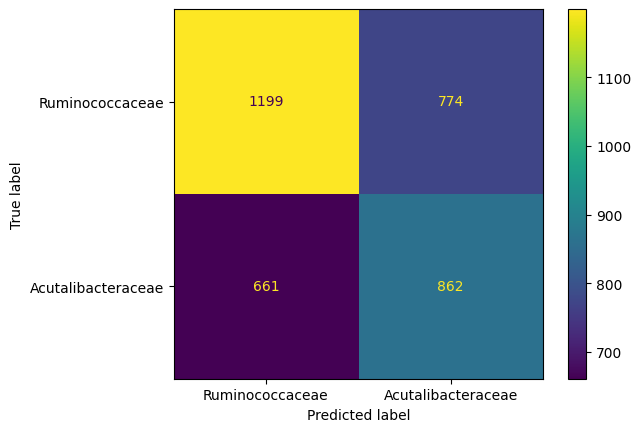

CPU times: user 14min 17s, sys: 14.4 s, total: 14min 31s
Wall time: 19min 36s


In [23]:
%%time
# launch it!
run_train()  # uncomment to run
beep.beep(secs=1)
# Using device: cuda:0
# Lachnospiraceae    64992
# Bacteroidaceae     34367
# Ruminococcaceae    26022
# Name: family, dtype: int64
# shape of u: torch.Size([1, 1069919, 256])
# shape of x and k: torch.Size([1, 256, 1069919]) torch.Size([256, 1069919])
# shape of y: torch.Size([1, 256, 1069919])
# y shape (operator): torch.Size([1, 1069919, 256])
# shape of u: torch.Size([1, 1069919, 256])
# shape of x and k: torch.Size([1, 256, 1069919]) torch.Size([256, 1069919])
#Loss: 0.669707 | Elapsed time: 1.6526081562042236

#### Inference (450k to 1M tokens)!

If all you're interested in is getting embeddings on long DNA sequences
(inference), then we can do that right here in Colab!


*   We provide an example how to load the weights from Huggingface.
*   On the free tier, which uses a
T4 GPU w/16GB of memory, we can process 450k tokens / nucleotides.
*   For processing 1M tokens, you'll need an A100, which Colab offers as a paid tier.
*   (Don't forget to run the entire notebook above too)

--

To pretrain or fine-tune the 1M long sequence model (8 layers, d_model=256),
you'll need 8 A100s 80GB, and all that code is in the main [github repo](https://github.com/HazyResearch/hyena-dna)!



In [28]:
#@title Single example
import json
import os
import subprocess
import transformers
from transformers import PreTrainedModel, AutoModelForCausalLM, PretrainedConfig

def inference_single():

    '''
    this selects which backbone to use, and grabs weights/ config from HF
    4 options:
      'hyenadna-tiny-1k-seqlen'   # fine-tune on colab ok
      'hyenadna-small-32k-seqlen'
      'hyenadna-medium-160k-seqlen'  # inference only on colab
      'hyenadna-medium-450k-seqlen'  # inference only on colab
      'hyenadna-large-1m-seqlen'  # inference only on colab
    '''

    # you only need to select which model to use here, we'll do the rest!
    pretrained_model_name = 'hyenadna-small-32k-seqlen'

    max_lengths = {
        'hyenadna-tiny-1k-seqlen': 1024,
        'hyenadna-small-32k-seqlen': 32768,
        'hyenadna-medium-160k-seqlen': 160000,
        'hyenadna-medium-450k-seqlen': 450000,  # T4 up to here
        'hyenadna-large-1m-seqlen': 1_000_000,  # only A100 (paid tier)
    }

    max_length = max_lengths[pretrained_model_name]  # auto selects

    # data settings:
    use_padding = True
    rc_aug = False  # reverse complement augmentation
    add_eos = False  # add end of sentence token

    # we need these for the decoder head, if using
    use_head = False
    n_classes = 2  # not used for embeddings only

    # you can override with your own backbone config here if you want,
    # otherwise we'll load the HF one in None
    backbone_cfg = None

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print("Using device:", device)

    # instantiate the model (pretrained here)
    if pretrained_model_name in ['hyenadna-tiny-1k-seqlen',
                                 'hyenadna-small-32k-seqlen',
                                 'hyenadna-medium-160k-seqlen',
                                 'hyenadna-medium-450k-seqlen',
                                 'hyenadna-large-1m-seqlen']:
        # use the pretrained Huggingface wrapper instead
        model = HyenaDNAPreTrainedModel.from_pretrained(
            './checkpoints',
            pretrained_model_name,
            download=True,
            config=backbone_cfg,
            device=device,
            use_head=use_head,
            n_classes=n_classes,
        )

    # from scratch
    elif pretrained_model_name is None:
        model = HyenaDNAModel(**backbone_cfg, use_head=use_head, n_classes=n_classes)

    # create tokenizer
    tokenizer = CharacterTokenizer(
        characters=['A', 'C', 'G', 'T', 'N'],  # add DNA characters, N is uncertain
        model_max_length=max_length + 2,  # to account for special tokens, like EOS
        add_special_tokens=False,  # we handle special tokens elsewhere
        padding_side='left', # since HyenaDNA is causal, we pad on the left
    )

    #### Single embedding example ####

    # create a sample 450k long, prepare
    sequence = 'ACTG' * int(max_length/4)
    tok_seq = tokenizer(sequence)
    tok_seq = tok_seq["input_ids"]  # grab ids

    # place on device, convert to tensor
    tok_seq = torch.LongTensor(tok_seq).unsqueeze(0)  # unsqueeze for batch dim
    tok_seq = tok_seq.to(device)

    # prep model and forward
    model.to(device)
    model.eval()
    with torch.inference_mode():
        embeddings = model(tok_seq)

    print(embeddings.shape)  # embeddings here!

In [ ]:
# # uncomment to run! (to get embeddings)
inference_single()

In [ ]:
#@title Batch example
"""
Let's say you want to do inference on a dataset to grab a lot of embeddings,
you can just loop thru a dataloader like this.

"""

import json
import os
import subprocess
import transformers
from transformers import PreTrainedModel, AutoModelForCausalLM, PretrainedConfig

# example, if you want to do look thru a dataloader and get embeddings

def infer_loop(model, device, test_loader):
    """inference loop."""
    # model.eval()

    with torch.inference_mode():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            # print embedding shape, or do something else here, like save.
            print('embeddings shape', output.shape)

def inference():

    '''
    this selects which backbone to use, and grabs weights/ config from HF
    4 options:
      'hyenadna-tiny-1k-seqlen'   # fine-tune on colab ok
      'hyenadna-small-32k-seqlen'
      'hyenadna-medium-160k-seqlen'  # inference only on colab
      'hyenadna-medium-450k-seqlen'  # inference only on colab
      'hyenadna-large-1m-seqlen'  # inference only on colab
    '''

    # select model
    pretrained_model_name = 'hyenadna-medium-160k-seqlen'  # use None if training from scratch

    max_lengths = {
        'hyenadna-tiny-1k-seqlen': 1024,
        'hyenadna-small-32k-seqlen': 32768,
        'hyenadna-medium-160k-seqlen': 160000,
        'hyenadna-medium-450k-seqlen': 450000,  # T4 up to here
        'hyenadna-large-1m-seqlen': 1_000_000,  # only A100 (paid tier)
    }

    # let's fix the max_length (to reduce the padding amount, conserves memory)
    max_length = 500

    # data settings:
    # we need to choose the dataset and batch size to loop thru
    dataset_name = 'human_enhancers_cohn'
    batch_size = 4
    use_padding = True
    rc_aug = False  # reverse complement augmentation
    add_eos = False  # add end of sentence token

    # we need these for the decoder head, if using
    use_head = False
    n_classes = 2  # not used for embeddings only

    # you can override with your own backbone config here if you want,
    # otherwise we'll load the HF one in None
    backbone_cfg = None

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print("Using device:", device)

    # instantiate the model (pretrained here)
    if pretrained_model_name in ['hyenadna-tiny-1k-seqlen',
                                 'hyenadna-small-32k-seqlen',
                                 'hyenadna-medium-160k-seqlen',
                                 'hyenadna-medium-450k-seqlen',
                                 'hyenadna-large-1m-seqlen']:
        # use the pretrained Huggingface wrapper instead
        model = HyenaDNAPreTrainedModel.from_pretrained(
            './checkpoints',
            pretrained_model_name,
            download=True,
            config=backbone_cfg,
            device=device,
            use_head=use_head,
            n_classes=n_classes,
        )

    # from scratch
    elif pretrained_model_name is None:
        model = HyenaDNAModel(**backbone_cfg, use_head=use_head, n_classes=n_classes)

    # create tokenizer
    tokenizer = CharacterTokenizer(
        characters=['A', 'C', 'G', 'T', 'N'],  # add DNA characters, N is uncertain
        model_max_length=max_length + 2,  # to account for special tokens, like EOS
        add_special_tokens=False,  # we handle special tokens elsewhere
        padding_side='left', # since HyenaDNA is causal, we pad on the left
    )

    # Sample small dataloader w/ GenomicBenchmarks

    ds_test = GenomicBenchmarkDataset(
        max_length = max_length,
        use_padding = use_padding,
        split = 'test',
        tokenizer=tokenizer,
        dataset_name=dataset_name,
        rc_aug=rc_aug,
        add_eos=add_eos,
    )

    ds_test = GenomicBenchmarkDataset(
        max_length = max_length,
        use_padding = use_padding,
        split = 'test',
        tokenizer=tokenizer,
        dataset_name=dataset_name,
        rc_aug=rc_aug,
        add_eos=add_eos,
    )

    test_loader = DataLoader(ds_test, batch_size=batch_size, shuffle=False)

    model.to(device)
    model.eval()

    infer_loop(model, device, test_loader)


In [ ]:
# uncomment to run!
# inference()